In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Уменьшение размерности

### Проклятие размерности (curse of fimintionality)

Часто датасеты состоят из очень большого числа признаков - тысячи
Это затрудняет поиск моделей.
Можно сильно уменьшить размерность без больших потерь информации, то есть сократить объем входных данныхб упростит расчет модели.

Рассмотрим единичный гиперкуб.
В двумерном пространстве это просто квадрат 1х1
Какова вероятность того, что точка попадает в отступ 0.001 от границы?

In [4]:
1 * 1 - (1 - 0.001 * 2) * (1 - 0.001 * 2)

0.0039959999999999996

In [7]:
def point_prob(n_dimindions, length, margin):
    return length ** n_dimindions - (length - margin * 2) ** (n_dimindions)

In [8]:
point_prob(2, 1, 0.001)

0.0039959999999999996

In [9]:
point_prob(3, 1, 0.001)

0.005988007999999989

In [10]:
point_prob(10, 1, 0.001)

0.019820956648050614

In [11]:
point_prob(10000, 1, 0.001)

0.999999997979714

Среднее расстояние между точками гиперкуба:

In [14]:
from scipy.spatial import distance

def avg_dist(n_dimensions):
    dist = 0.
    n_points = 100000
    for i in range(n_points):
        p1 = np.random.rand(n_dimensions)
        p2 = np.random.rand(n_dimensions)
        dist += distance.euclidean(p1, p2)
    return dist / n_points

In [15]:
 avg_dist(1)

0.33137948220920066

In [16]:
avg_dist(2)

0.5215992583914029

In [18]:
avg_dist(3)

0.662228748244025

In [20]:
avg_dist(10000)

40.824156857717604

Новая точка будет далеко от других, это означает, что построенная модель скорее всего не учитывает новые данные, то есть модель недообучена

# PCA - Principal Component Analysis (метод главных компонент)

найти подпространство меньшей размерности, в ортогональной проекции на которые разброс данных (то есть среднеквадратическое отклонение от
среднего значения) максимален

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных

Будет выбирать такую ось, в которой сохраняется максимальное количество дисперсии. Так мы вероятно потеряем меньше информации
при проецировании.
Следующая ось ортогональна первой, выбирается из всех других осей как ось с наибольшей оставшейся дисперсией.

# Explaned Variance (Объясненная дисперсия) 

In [21]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

scaler = StandardScaler()

X_iris_scaled = scaler.fit_transform(X_iris)

pca = PCA()
pca.fit(X_iris_scaled)

PCA()

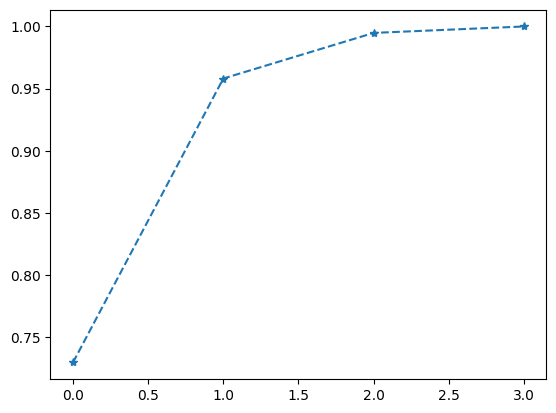

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), '*--')

In [25]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [23]:
x_new = PCA(n_components=2).fit_transform(X_iris_scaled)
x_new.shape

(150, 2)

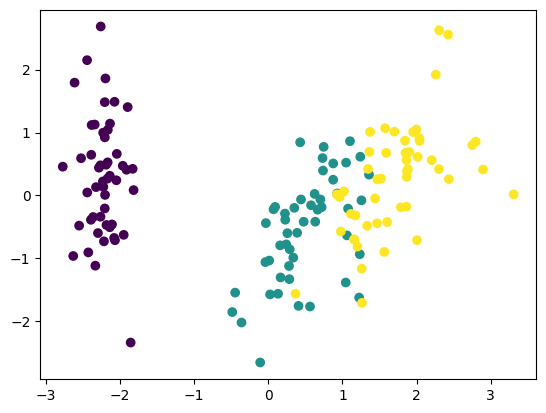

In [24]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=y_iris);

# Данные посложнее

In [44]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, as_frame = False, return_X_y=True)

In [45]:
X.shape, y.shape

((70000, 784), (70000,))

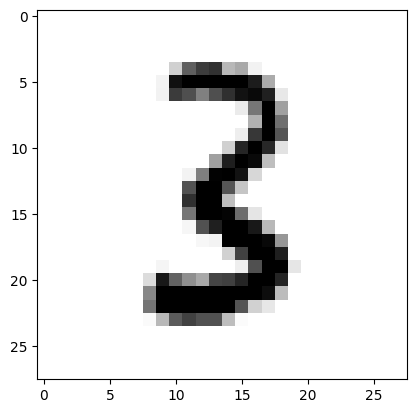

In [46]:
plt.imshow(X[50000].reshape(28, 28), cmap=plt.cm.gray_r)

In [47]:
pca = PCA()
pca.fit(scaler.fit_transform(X))
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= .95) + 1
d

332

In [48]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

Text(0, 0.5, '% explained variance')

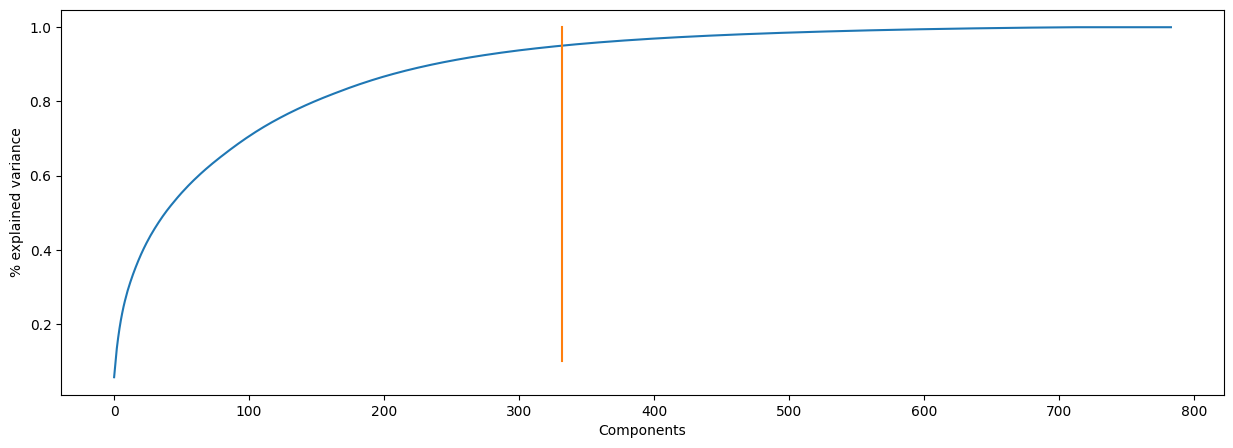

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(cumsum)
plt.plot([d, d], [0.1, 1])
plt.xlabel('Components')
plt.ylabel('% explained variance')
#plt.show()

* PCA понижает размерность знакового пространства
* Новые компоненты являются линейной комбинацией исходных признаков
* Новые компоненты - ортогональны
* Можно применять в моделях для визуализации
* Работает не всегда

# Применение для визуализации

In [50]:
idx = np.random.randint(X.shape[0], size=10000)
X_sample = X[idx, :]
y_sample = y[idx]

X_sample.shape, X.shape, y_sample.shape, y.shape

((10000, 784), (70000, 784), (10000,), (70000,))

In [51]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_sample)

In [52]:
X_reduced.shape

(10000, 2)

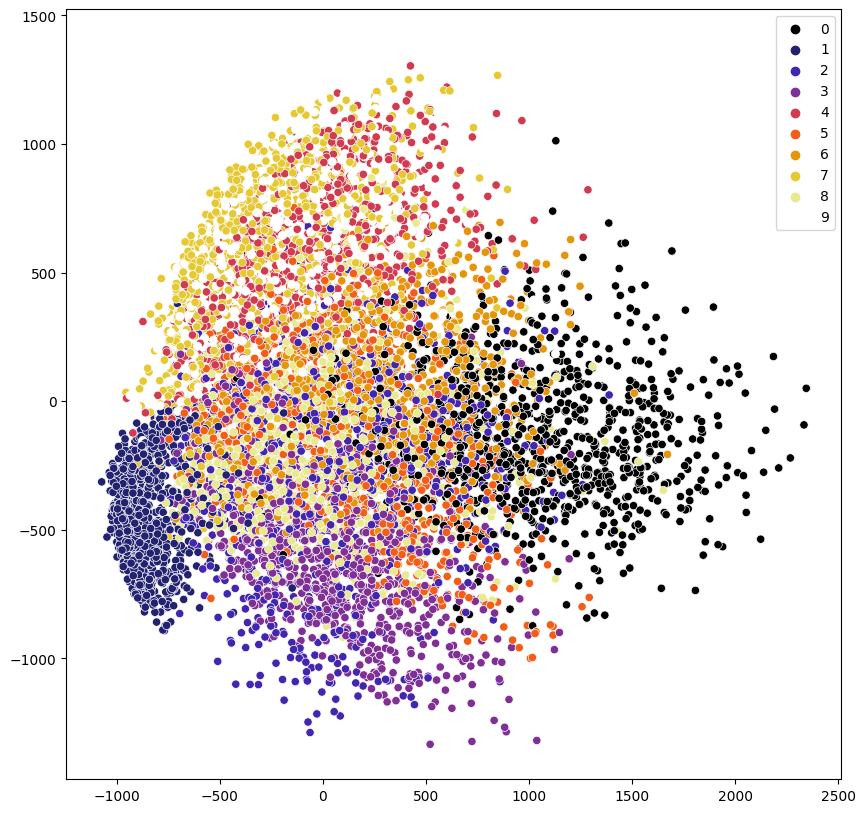

In [53]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=y_sample.astype(int),
    palette='CMRmap',
    legend='full'
);

# TSNE

In [60]:
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE
    
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_sample)

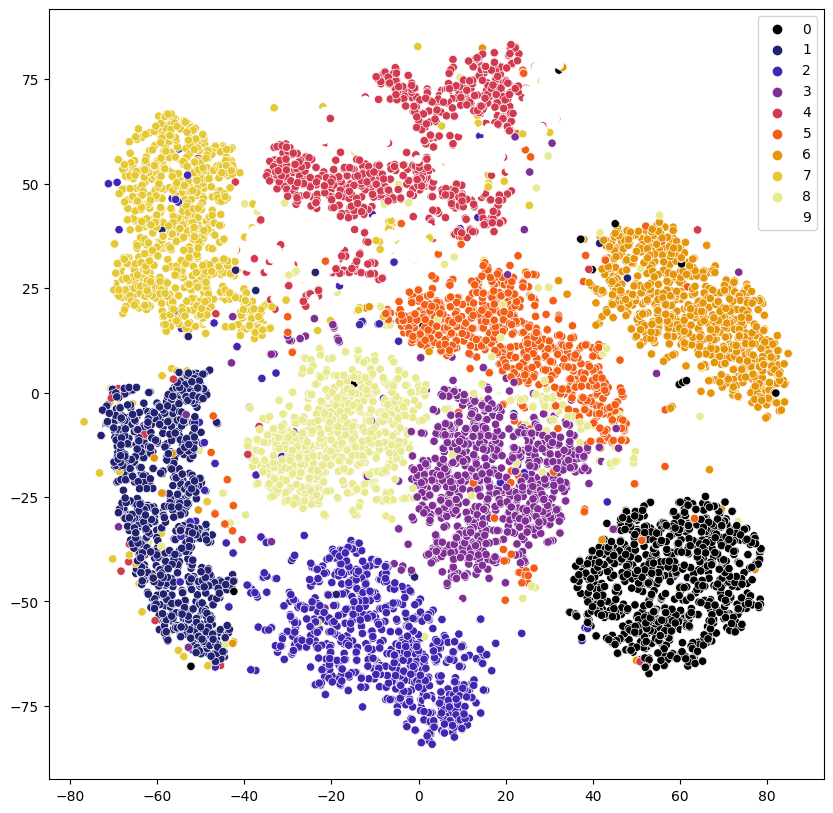

In [61]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],
    hue=y_sample.astype(int),
    palette='CMRmap',
    legend='full'
);

In [62]:
def analyze_PCA(X, pca, explained_threshold=.95):
    """
    Plot cummulative explained variance of PCA
    """
    pca.fit(X)
    pca_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(15, 7))
    plt.plot(np.cumsum(pca_variance))
    plt.hlines(explained_threshold, 0, len(pca_variance))
    plt.title('Number of components to explain {}% of variance: {}'.format(
        100 * explained_threshold, np.argwhere(np.cumsum(pca_variance)>.95)[0]
    ))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

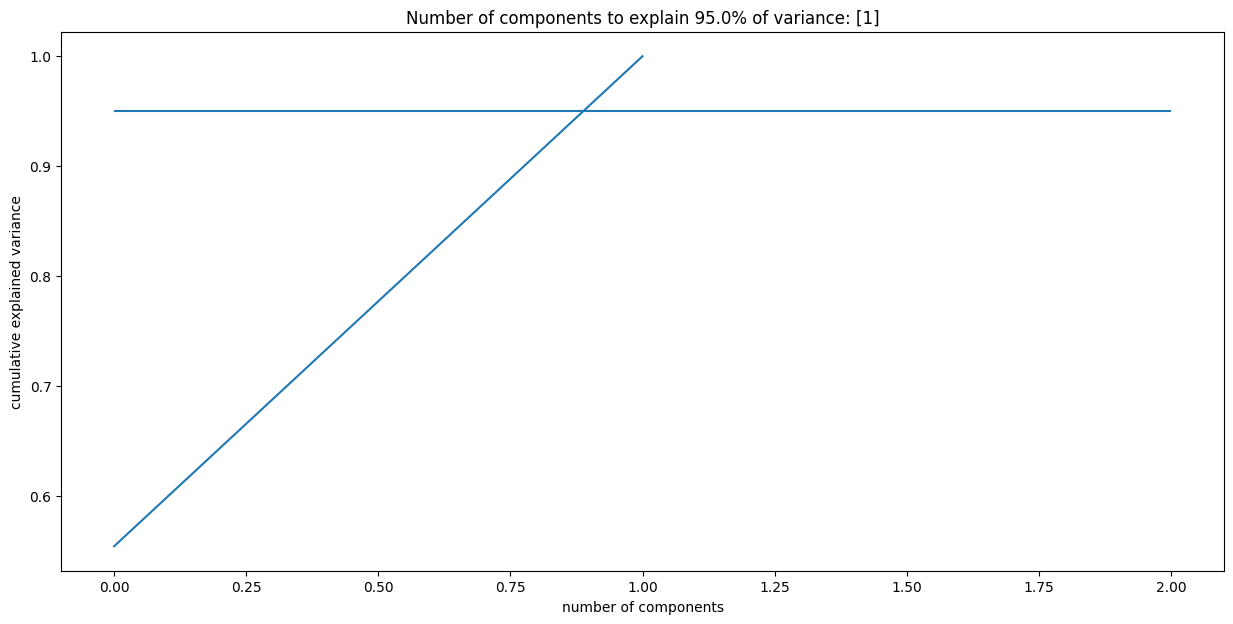

In [66]:
analyze_PCA(tsne_transformed, pca)